## Import libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time
import requests
import re
import nltk

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, plot_confusion_matrix, plot_roc_curve
from sklearn.preprocessing import StandardScaler

from nltk.stem import WordNetLemmatizer
from nltk.stem.porter import PorterStemmer

# Wordcloud imports

from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

import warnings
warnings.filterwarnings(action='ignore')

### Webscraping Functions

In [2]:
# def get_posts_batch(subreddit, before):
    
#     url = 'https://api.pushshift.io/reddit/search/submission'
    
#     params = {
#         'subreddit': subreddit,
#         'size': 100
#     }
#     if before is not None: 
#         params['before'] = before
        
#     res = requests.get(url, params)

#     return res.json()

# def posts_to_df(posts):
#     data = posts['data']
    
#     df = pd.DataFrame(data)
#     return df[['subreddit', 'id', 'author', 'score', 'title', 'selftext', 'num_comments', 'created_utc']]

# def get_posts(subreddit, num_posts):
    
#     post_ids = set()
    
#     before = None
    
#     i = 0
    
#     while len(post_ids) < num_posts:
#         batch = get_posts_batch(subreddit, before)
        
#         df = posts_to_df(batch)
        
#         before = df['created_utc'].min()
        
#         post_ids.update(df['id'])
        
#         if i == 0: 
#             header = True
#             mode = 'w'
#         else: 
#             header = False 
#             mode = 'a'
#         df.to_csv(subreddit + '.csv', mode=mode, header=header, index=False)
#         print(f'We have scraped {len(post_ids)} posts.')
#         i += 1
#         time.sleep(2)

### Retrieving/Reading in The Rolling Stones Data

In [3]:
# get_posts('rollingstones', 5000)

In [4]:
# Reading in the Rolling Stones data
rollingstones = pd.read_csv('./data/rollingstones.csv')

In [5]:
rollingstones.drop(rollingstones.tail(98).index, inplace=True)

In [6]:
# rollingstones.head(2)

### DataFrame Basics - The Rolling Stones

In [7]:
# rollingstones.info()

In [8]:
# rollingstones.isnull().sum()

In [9]:
# Due to the overwhelming amount of NaN values in the 'selftext' column, I am choosing to drop this column.
# The title gives just as much information I believe and has 0 null values gives enough description on the reddit post. 
rollingstones.drop(columns=['id', 'selftext', 'created_utc'], inplace=True)

### Retrieving/Reading in The Beatles Data

In [10]:
# get_posts('TheBeatles', 5000)

In [11]:
# Reading in The Beatles data
thebeatles = pd.read_csv('./data/TheBeatles.csv')

In [12]:
# thebeatles.head(2)

### DataFrame Basics - The Beatles

In [13]:
# thebeatles.info()

In [14]:
# thebeatles.isnull().sum()

In [15]:
# Due to the overwhelming amount of NaN values in the 'selftext' column, I am choosing to drop this column.
# The title gives just as much information I believe and has 0 null values gives enough description on the reddit post.
thebeatles.drop(columns=['id', 'selftext', 'created_utc'], inplace=True)

### Joining DataFrame Subreddits

In [16]:
beatles_stones = pd.concat([thebeatles, rollingstones])
beatles_stones.reset_index(inplace=True)
beatles_stones = beatles_stones.drop(columns=['index'])

### DataFrame Cleaning

In [17]:
beatles_stones['title'] = beatles_stones['title'].apply(lambda x: re.split('https:\/\/.*', str(x))[0])

In [18]:
beatles_stones['title_nopunc'] = beatles_stones['title'].str.replace(r'[^\w\s]+', '').str.lower()

In [19]:
# Using loc function provided by Denise to see if any other URLs which do not contain https are lingering in the rows of the df.
# beatles_stones.loc[beatles_stones['title_nopunc'].str.contains('.com', regex=False)]

In [20]:
# Mapping my subreddits
beatles_stones['subreddit'] = beatles_stones['subreddit'].map({'TheBeatles': 0, 'rollingstones': 1})

In [21]:
# Adding title word count and title length before making a copy of the dataframe for EDA. 

beatles_stones['title_length'] = beatles_stones['title'].transform(len)

beatles_stones['title_word_count'] = beatles_stones['title'].map(lambda x: len(x.split(' ')))

## Stemming and Lemmatizing

In [22]:
# Since I will be making a copy of my dataframe before EDA, I am choosing to stem and lemmatize so I can have the option of performing EDA on the 
# title column after stemming and lemmatizing occurs to see what effect this may have on my corpus.

In [23]:
p_stemmer = PorterStemmer()

In [24]:
stem_roll = [p_stemmer.stem(i) for i in beatles_stones['title_nopunc']]

In [25]:
beatles_stones['title_nopunc'].map(p_stemmer.stem).head(1)

0    battle of the beatles match 100  real love vs ...
Name: title_nopunc, dtype: object

In [26]:
beatles_stones['p_stem_title'] = beatles_stones['title_nopunc'].map(p_stemmer.stem)

In [27]:
lemmatizer = WordNetLemmatizer()

In [28]:
lem_title = [lemmatizer.lemmatize(x) for x in beatles_stones['title_nopunc']]

In [29]:
beatles_stones['lem_title'] = lem_title

In [30]:
df_eda = beatles_stones.copy()

## EDA 1 - Title Length & Word Count Distributions

In [31]:
# Making columns and distributions for title length and title word count to discern if any patterns exist.
# Also, giving the model more options on features to train on when needing to predict subreddit. 
df_eda['title_length'] = df_eda['title'].transform(len)

In [32]:
df_eda['title_word_count'] = df_eda['title'].map(lambda x: len(x.split(' ')))

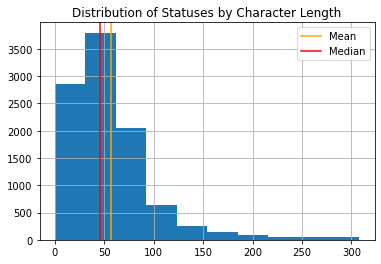

In [33]:
df_eda['title_length'].hist()
plt.axvline(df_eda.title_length.mean(), color='orange')
plt.axvline(df_eda.title_length.median(), color='red')
plt.legend(['Mean','Median'])
plt.title('Distribution of Statuses by Character Length');

# The average character length for the subreddits I am analysing is ~56 characters. 
# The median character length is 46.

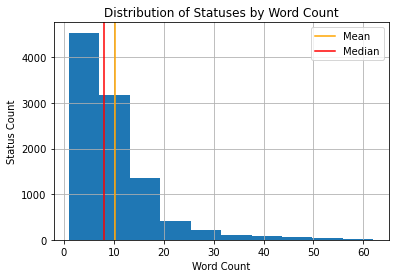

In [34]:
df_eda['title_word_count'].hist()
plt.axvline(df_eda.title_word_count.mean(), color='orange')
plt.axvline(df_eda.title_word_count.median(), color='red')
plt.legend(['Mean','Median'])
plt.title('Distribution of Statuses by Word Count')
plt.xlabel('Word Count')
plt.ylabel('Status Count');

# The average title word count for the subreddits I am analysing is ~10 words. 
# The median title word count is 8 words. 

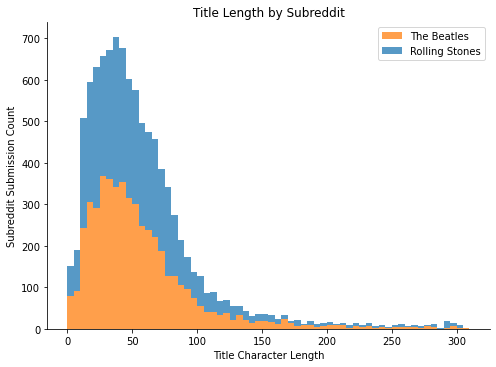

In [35]:
sns.displot(df_eda, 
           x='title_length',
           hue='subreddit',
           binwidth=5, 
           height=5, 
           aspect=1.4, 
           edgecolor='none', 
           multiple='stack', 
           legend=False
           ).set(title='Title Length by Subreddit')
plt.legend(['The Beatles', 'Rolling Stones'])
plt.xlabel('Title Character Length')
plt.ylabel('Subreddit Submission Count');

# Using a hue, the Rolling Stones subreddit users seem to be much more passionate purely 
# based off the character length average of each submission. This distinction could help my model in predicting between the two
# subreddits. 

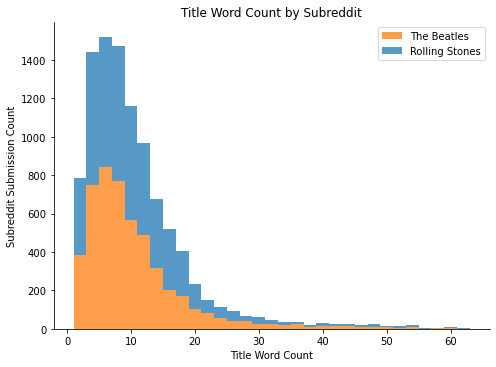

In [36]:
sns.displot(df_eda, 
           x='title_word_count',
           hue='subreddit',
           binwidth=2, 
           height=5, 
           aspect=1.4, 
           edgecolor='none', 
           multiple='stack', 
           legend=False
           ).set(title='Title Word Count by Subreddit')
plt.legend(['The Beatles', 'Rolling Stones'])
plt.xlabel('Title Word Count')
plt.ylabel('Subreddit Submission Count');

# Using a hue, I can see a big distinction between the two subreddits title word counts. The subreddit users on the Rolling Stones
# are much more 'talkative' in their posts. Again, this could help my model in predicting between the two subreddits. 

## EDA 1 Conclusion: 

All of the distributions when analyzing title word count and character length count are right skewed. The average character length between both subreddits is ~56 characters and the median character length is 46. In regards to title word count, the average title word count between both subreddits is ~10 words and the median title word count is 8 words. 

Biggest takeaway from EDA 1: 
When using a Seaborn displot and hue, I found the r/rollingstones to have a greater character length and word count for their title submissions. Since these features are numeric, I will use them with my model to help distinguish between the two subreddits. 

## Subreddit Title Word Clouds

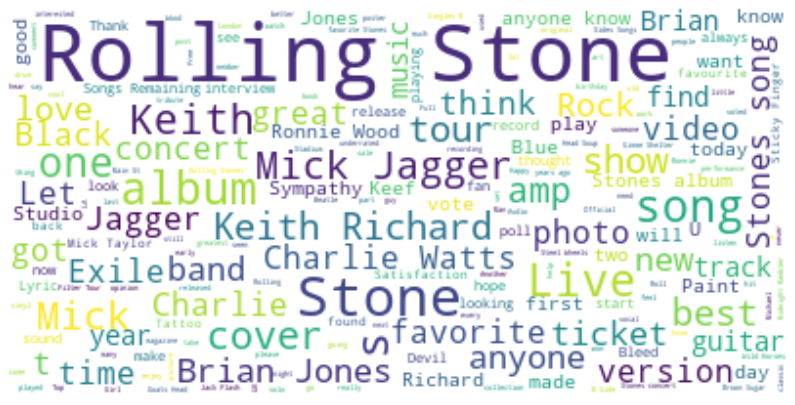

In [37]:
# Generated a wordcloud for the Rolling Stones dataframe. 
plt.figure(figsize=(14, 14))
word_count = ''.join(title for title in rollingstones.title)

stopwords=set(STOPWORDS)

wordcloud = WordCloud(stopwords=stopwords, background_color='white').generate(word_count)

plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

# Not surprisingly the band name is the most common word pair used in this subreddit followed by the names of the two most popular
# members - lead singer Mick Jagger & lead guitarist Keith Richards. Before adding these common words to the stopwords list, I will
# run a model first to establish an initial modeling score. 

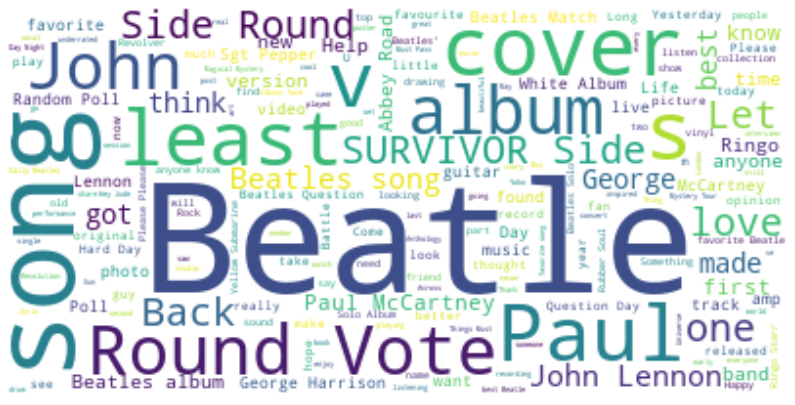

In [38]:
# Generated a wordcloud for The Beatles dataframe. 
plt.figure(figsize=(14, 14))
word_count = ''.join(title for title in thebeatles.title)

stopwords=set(STOPWORDS)

wordcloud = WordCloud(stopwords=stopwords, background_color='white').generate(word_count)

plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

# As with the Rolling Stones subreddit word cloud, the band name and 
# two most notable members are some of the most often used. 
# However, the words cover, album, and vote which are frequently 
# used in this subreddit are rarely used in the rolling stones subreddit. 

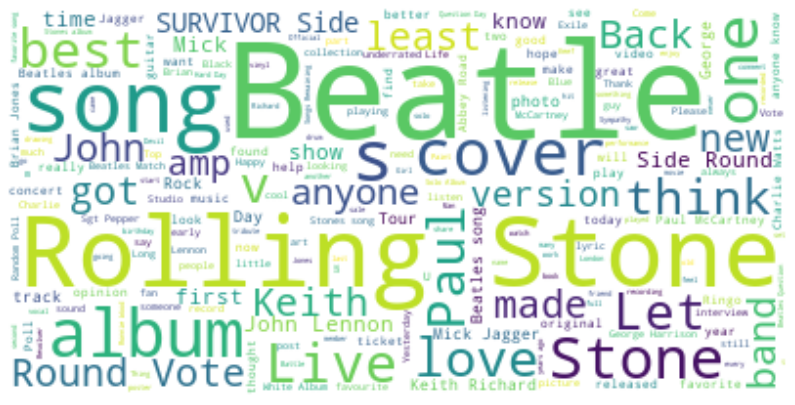

In [39]:
# Generated a wordcloud for the combined dataframes. 
# Generated a wordcloud for the individual Rolling Stones dataframe. 
plt.figure(figsize=(14, 14))
word_count = ''.join(title for title in beatles_stones.title)

stopwords=set(STOPWORDS)

wordcloud = WordCloud(stopwords=stopwords, background_color='white').generate(word_count)

plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

# The Beatles band name tend to appear more in these subreddits than the 
# Rolling Stones band name by a fraction. 

## WordCloud Conclusions: 

I was curious at making individual wordclouds for the subreddits to see if the size (frequency) of particular words were the same across both. However, I found a few interesting exceptions in The Beatles wordcloud which were the words cover, album, and vote. When looking at the beatles and rolling stones combined, I found the words most commonly used to be song, album, love, and Let(It Be). Based solely off these common words, I can see a bit more influence coming from the beatles subreddit than the rolling stones subreddit. 

## CountVectorizer

In [40]:
cvex = CountVectorizer(max_df = 800, stop_words='english')

In [41]:
cvex_df = cvex.fit_transform(df_eda['title_nopunc'])

In [42]:
cvex_df

<10000x8605 sparse matrix of type '<class 'numpy.int64'>'
	with 53162 stored elements in Compressed Sparse Row format>

In [43]:
cvex_df = pd.DataFrame(cvex_df.todense(), columns=cvex.get_feature_names_out())

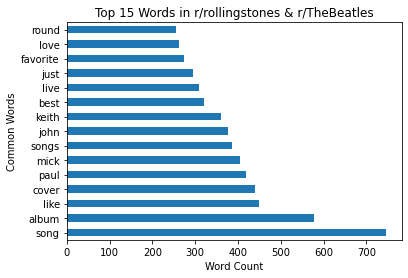

In [44]:
# Bar chart of 15 most common words
cvex_df.sum().sort_values(ascending=False).head(15).plot(kind='barh')
plt.xlabel('Word Count')
plt.ylabel('Common Words')
plt.title('Top 15 Words in r/rollingstones & r/TheBeatles');

# When running the count vectorizer with no max_df, the words beatles, rolling, and stones appeared well over 1000 times each. 
# As a result, I decided to set a max_df of 800 so I could make room for what other words in the submission titles were used 
# frequently. The words song, album, and like are the top 3 which may end up being a struggle for my model when predicting
# as these could just as easily exist in one as well as the other. Luckily though, none of the band member names are shared. 

In [45]:
bi = CountVectorizer(ngram_range=(2, 2), stop_words='english')
bi_cv_df = bi.fit_transform(df_eda['title_nopunc'])
bi_cv_df = pd.DataFrame(bi_cv_df.todense(), columns=bi.get_feature_names_out())

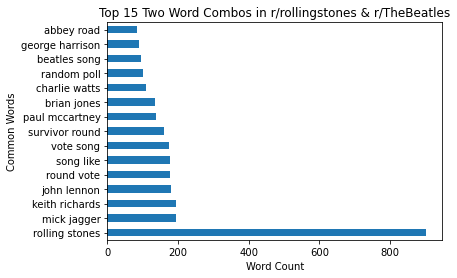

In [46]:
# Bar chart of 15 most common word combos
bi_cv_df.sum().sort_values(ascending=False).head(15).plot(kind='barh')
plt.xlabel('Word Count')
plt.ylabel('Common Words')
plt.title('Top 15 Two Word Combos in r/rollingstones & r/TheBeatles');

# I imagine because I removed stopwords from my count vectorizer the beatles doesn't appear in the top word combos, but instead
# rolling stones wins out. However, I am surprised how far down the list Paul McCartney sits compared to Mick Jagger, 
# Keith Richards, and John Lennon. 

In [47]:
bigram_lem_df = bi.fit_transform(df_eda['lem_title'])
bigram_lem_df = pd.DataFrame(bigram_lem_df.todense(), columns=bi.get_feature_names_out())

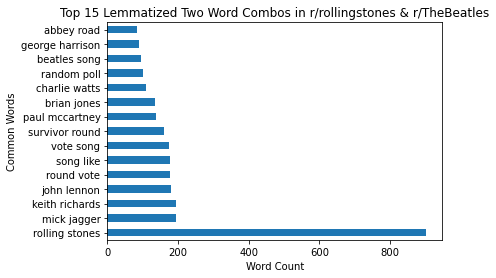

In [48]:
bigram_lem_df.sum().sort_values(ascending=False).head(15).plot(kind='barh')
plt.xlabel('Word Count')
plt.ylabel('Common Words')
plt.title('Top 15 Lemmatized Two Word Combos in r/rollingstones & r/TheBeatles');

# When examining the lemmatized title column, the top three word combos are Rolling Stones, Mick Jagger, and Keith Richards.
# I wanted to see how lemmatizing and stemming may change which common words appear. 

In [49]:
bigram_stem_cv = bi.fit_transform(df_eda['p_stem_title'])
bigram_stem_cv = pd.DataFrame(bigram_stem_cv.todense(), columns=bi.get_feature_names_out())

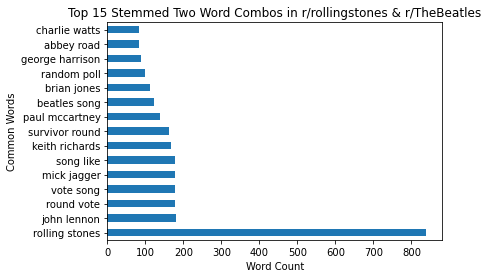

In [50]:
bigram_stem_cv.sum().sort_values(ascending=False).head(15).plot(kind='barh')
plt.xlabel('Word Count')
plt.ylabel('Common Words')
plt.title('Top 15 Stemmed Two Word Combos in r/rollingstones & r/TheBeatles');

# The top three word combos when examining the p_stem_title column are Rolling Stones, John Lennon, and round vote. Although I am not certain how these two
# methods are interacting with the words, they have decided a different order of importance. 

## CountVectorizer EDA Conclusions: 

When running the CountVectorizer without any hyperparameters aside from english stopwords taken out, the words beatles, rolling, and stones appeared well over 800 times each. As a result, I decided to set a max_df of 800 so I could make room for what other less obvious words in the submission titles were used frequently. The words song, album, and like are the top 3 which may end up being a struggle for my model as either of these could just as easily exist in one subreddit as the other. The one advantage my model will have is none of the band member names are shared. 
Although I am not entirely sure the finer details of stemming and lemmatizing, when examining the title columns which were stemmed and lemmatized I found the common word combo order changed slightly. I will keep this in mind when considering those columns as features in my model. More specifically, I would much rather use the lemmatized title column since this was able to pick out much more discernable word combos helpful to my model's predictions between the two different subreddits. 

## TFIDFVectorizer

In [51]:
tvec = TfidfVectorizer(max_df=800, min_df=1, stop_words='english')

In [52]:
tvec_df = tvec.fit_transform(df_eda['title_nopunc'])

In [53]:
tvec_df = pd.DataFrame(tvec_df.todense(), columns=tvec.get_feature_names_out())

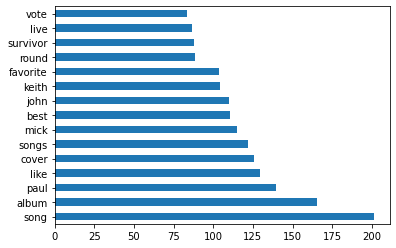

In [54]:
# Bar Chart of 15 most common words according to TFIDFVectorizer
tvec_df.sum().sort_values(ascending=False).head(15).plot(kind='barh');
# Unlike with the count vectorizer, song, album, and paul are the top 3 words in submission titles. 

In [55]:
bi_tvec = TfidfVectorizer(ngram_range=(2, 2), stop_words='english')
bi_tvec_df = bi_tvec.fit_transform(df_eda['title_nopunc'])
bi_tvec_df = pd.DataFrame(bi_tvec_df.todense(), columns=bi_tvec.get_feature_names_out())

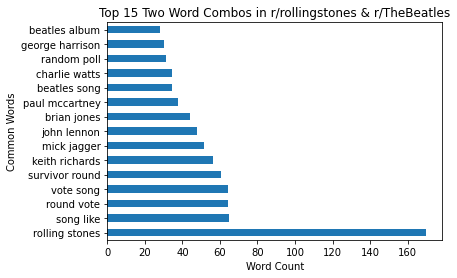

In [56]:
# Barchart of 15 most common word combos according to TFIDFVectorizer
bi_tvec_df.sum().sort_values(ascending=False).head(15).plot(kind='barh')
plt.xlabel('Word Count')
plt.ylabel('Common Words')
plt.title('Top 15 Two Word Combos in r/rollingstones & r/TheBeatles');
# Again as with the count vectorizer, rolling stones is found to be the most common word combo for subreddit title submissions. 
# However, I am seeing a swift departure in what the TfidfVectorizer has found to be common across subreddit title posts. 

In [57]:
bigram_lem_tvec = bi.fit_transform(df_eda['lem_title'])
bigram_lem_tvec = pd.DataFrame(bigram_lem_tvec.todense(), columns=bi.get_feature_names_out())

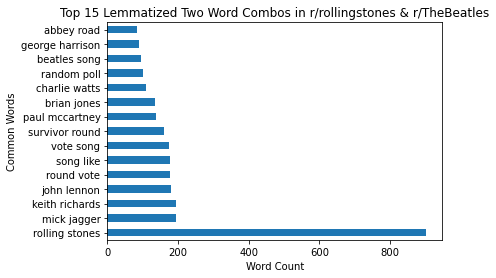

In [58]:
bigram_lem_tvec.sum().sort_values(ascending=False).head(15).plot(kind='barh')
plt.xlabel('Word Count')
plt.ylabel('Common Words')
plt.title('Top 15 Lemmatized Two Word Combos in r/rollingstones & r/TheBeatles');

# As mentioned previously, I wanted to see what, if any, difference looking at the stemmed and lemmatized title columns made in identifying the common words
# of subreddits. Again, lemmatizing does a fair job at picking out notable band members and the band name of one subreddit. 

In [59]:
bigram_stem_tvec = bi_tvec.fit_transform(df_eda['p_stem_title'])
bigram_stem_tvec = pd.DataFrame(bigram_stem_tvec.todense(), columns=bi_tvec.get_feature_names_out())

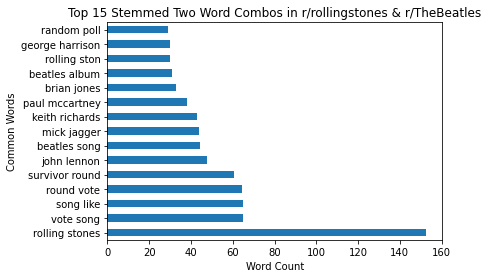

In [60]:
bigram_stem_tvec.sum().sort_values(ascending=False).head(15).plot(kind='barh')
plt.xlabel('Word Count')
plt.ylabel('Common Words')
plt.title('Top 15 Stemmed Two Word Combos in r/rollingstones & r/TheBeatles');

# As mentioned previously, I wanted to see what, if any, difference looking at the stemmed and lemmatized title columns made in identifying the common words
# of subreddits. Again, stemming does not perform as well overall with picking out word combos I believe to be helpful in distinguishing between 
# two different subreddits. 

## TFIDF Vectorizer Conclusions: 

Overall, the TFIDFVectorizer didn't do as good of a job in my opinion at picking out words or word combos which would help my model distinguish between two different subreddits. For example, the top three words in submission titles were song, album and paul which aside from Paul could exist in either subreddit quite frequently. The lemmatizer won out in this vectorizer as well with being able to pick out a better set of common words. 

Biggest takeaway: After running some charts on both CountVectorizer and TFIDFVectorizer with stemming and lemmatizing as well, I think CountVectorizer will be my vectorizer of choice as this was able to pull highly distinguishable words and word combos which would be helpful for my model to predict between two different subreddits. 

# Initial Interpretation of Coefficients of Numeric Columns

In [61]:
# Based off the hue histogram I ran on title length and title word count, I would like to see how well the numeric columns are at helping model predict between the two different subreddits.

In [62]:
subred_numeric = beatles_stones.select_dtypes(include=int)

In [63]:
X = subred_numeric.drop(columns='subreddit')
y = subred_numeric['subreddit']

In [64]:
# Train/test/split
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    stratify=y, 
                                                    random_state=9)

In [65]:
# Scaling model for good measure
ss = StandardScaler()
Z_train = ss.fit_transform(X_train)
Z_test = ss.transform(X_test)

In [66]:
# Instantiate model
logreg = LogisticRegression(solver='liblinear')

In [67]:
# Fit the model
logreg.fit(Z_train, y_train)

LogisticRegression(solver='liblinear')

In [68]:
# Baseline accuracy
y_test.value_counts(normalize=True)

1    0.5
0    0.5
Name: subreddit, dtype: float64

In [69]:
# Training accuracy
logreg.score(Z_train, y_train)

0.5637333333333333

In [70]:
# Testing accuracy
logreg.score(Z_test, y_test)

0.5588

In [71]:
# Checking out coefficients
pd.Series(np.exp(logreg.coef_[0]), index=X.columns).sort_values(ascending=False)

title_length        4.151783
num_comments        1.163596
score               0.942308
title_word_count    0.231690
dtype: float64

In [72]:
# All else held constant an increase in title character length gives us a 4x greater chance of predicting the positive classifier 
# which is r/rollingstones. 

#### Model evaluation: 
Although the coefficients of title_length and num_comments may show a strong correlation with predicting the positive classifier, the model barely performed better than the baseline accuracy. I will run my models and see how well my models perform without using these numeric columns. 

# Baseline Model

In [73]:
from sklearn.dummy import DummyClassifier

In [74]:
# Train/test/split
X = beatles_stones['title_nopunc']
y = beatles_stones['subreddit']

In [75]:
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                   random_state=9, 
                                                   stratify=y)

In [76]:
pipe_dummy = Pipeline([
    ('cvec', CountVectorizer()), 
    ('dummy', DummyClassifier(strategy='most_frequent'))
])

In [77]:
# Estimate how model will perform on unseen data.
cross_val_score(pipe_dummy, X_train, y_train, cv=5).mean()
# 0.5

0.5

In [78]:
pipe_params = {
    'cvec__max_features': [3000, 4000, 5000, 6000], 
    'cvec__min_df': [1, 2, 3], 
    'cvec__max_df': [.95], 
    'cvec__ngram_range': [(1, 1), (1, 2)]
}

In [79]:
gs = GridSearchCV(pipe_dummy, 
                 param_grid=pipe_params, 
                 cv=5)

In [80]:
gs.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('cvec', CountVectorizer()),
                                       ('dummy',
                                        DummyClassifier(strategy='most_frequent'))]),
             param_grid={'cvec__max_df': [0.95],
                         'cvec__max_features': [3000, 4000, 5000, 6000],
                         'cvec__min_df': [1, 2, 3],
                         'cvec__ngram_range': [(1, 1), (1, 2)]})

In [81]:
gs.best_score_

0.5

In [82]:
gs.best_params_

{'cvec__max_df': 0.95,
 'cvec__max_features': 3000,
 'cvec__min_df': 1,
 'cvec__ngram_range': (1, 1)}

In [83]:
# Score on dummy classifier training set
gs.score(X_train, y_train)

0.5

In [84]:
# Score on dummy classifier testing set
gs.score(X_test, y_test)

0.5

#### Evaluation of DummyClassifier: 
Before running my models, I wanted to get an idea of what the baseline model scoring was - not surprisingly the cross_val, training, and testing scores all clocked in at 0.5 because the data was a balanced class. This will help us determine how well our models are performing. 

# Pipeline on multiple models

In [85]:
model_scores = pd.DataFrame(columns = ['Cross Validation Score', 'Training Score', 'Testing Score'], 
                          index = ['RandomForestClassifier_cvec', 'MultinomialNB_cvec', 'KNeighborsClassifier_cvec', 
                                   'RandomForestClassifier_tvec', 'MultinomialNB_tvec', 'KNeighborsClassifier_tvec'])

### CountVectorizer & Random Forest

In [86]:
# Train/test/split
X = beatles_stones['title_nopunc']
y = beatles_stones['subreddit']

In [87]:
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                   random_state=9, 
                                                   stratify=y)

In [88]:
pipe = Pipeline([
    ('cvec', CountVectorizer()), 
    ('rfc', RandomForestClassifier())
])

In [89]:
# Estimate how model will perform on unseen data.
cross_val_score(pipe, X_train, y_train, cv=5).mean()
# 0.8736

0.8726666666666667

In [90]:
pipe_params = {
    'cvec__max_features': [3000, 4000, 5000, 6000], 
    'cvec__min_df': [1, 2, 3], 
    'cvec__max_df': [.95], 
    'cvec__ngram_range': [(1, 1), (1, 2)]
}

In [91]:
gs = GridSearchCV(pipe, 
                 param_grid=pipe_params, 
                 cv=5)

In [92]:
gs.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('cvec', CountVectorizer()),
                                       ('rfc', RandomForestClassifier())]),
             param_grid={'cvec__max_df': [0.95],
                         'cvec__max_features': [3000, 4000, 5000, 6000],
                         'cvec__min_df': [1, 2, 3],
                         'cvec__ngram_range': [(1, 1), (1, 2)]})

In [93]:
# Best score through GridSearchCV
gs.best_score_
# 0.8752000000000001

0.8738666666666667

In [94]:
gs.best_params_
# {'cvec__max_df': 0.95,
#  'cvec__max_features': 3000,
#  'cvec__min_df': 1,
#  'cvec__ngram_range': (1, 2)}

{'cvec__max_df': 0.95,
 'cvec__max_features': 6000,
 'cvec__min_df': 2,
 'cvec__ngram_range': (1, 2)}

In [95]:
# Score model on training set.
gs.score(X_train, y_train)
# 0.9941333333333333

0.9904

In [96]:
# Score model on testing set.
gs.score(X_test, y_test)
# 0.888

0.8856

In [97]:
model_scores.loc['RandomForestClassifier_cvec'] = [0.87, 0.99, 0.88]

#### Model Evaluation: 
Based off the accuracy score, the model is overfit with a .11 difference between training and testing scores. I will continue looking into other models. I want to first see model scoring without digging too deep into hyperparameters just yet. 

### CountVectorizer & MultinomialNB

In [98]:
pipe = Pipeline([
    ('cvec', CountVectorizer()), 
    ('nb', MultinomialNB())
])

In [99]:
# Estimate how model will perform on unseen data.
cross_val_score(pipe, X_train, y_train, cv=5).mean()
# 0.8847999999999999

0.8847999999999999

In [100]:
pipe_params = {
    'cvec__max_features': [3000, 4000, 5000, 6000], 
    'cvec__min_df': [1, 2, 3], 
    'cvec__max_df': [.95], 
    'cvec__ngram_range': [(1, 1), (1, 2)]
}

In [101]:
gs = GridSearchCV(pipe, 
                 param_grid=pipe_params, 
                 cv=5)

In [102]:
gs.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('cvec', CountVectorizer()),
                                       ('nb', MultinomialNB())]),
             param_grid={'cvec__max_df': [0.95],
                         'cvec__max_features': [3000, 4000, 5000, 6000],
                         'cvec__min_df': [1, 2, 3],
                         'cvec__ngram_range': [(1, 1), (1, 2)]})

In [103]:
# Best score through GridSearchCV
gs.best_score_
# 0.8832000000000001

0.8837333333333334

In [104]:
gs.best_params_
# {'cvec__max_df': 0.95,
#  'cvec__max_features': 6000,
#  'cvec__min_df': 1,
#  'cvec__ngram_range': (1, 2)}

{'cvec__max_df': 0.95,
 'cvec__max_features': 6000,
 'cvec__min_df': 1,
 'cvec__ngram_range': (1, 1)}

In [105]:
# Score model on training set.
gs.score(X_train, y_train)
# 0.9218666666666666

0.9313333333333333

In [106]:
# Score model on testing set.
gs.score(X_test, y_test)
# 0.8912

0.886

In [107]:
model_scores.loc['MultinomialNB_cvec'] = [0.88, 0.93, 0.89]

#### Model evaluation: 
Again, the model is overfit but with fair improvement from the other training and testing scores of the RandomForestClassifier. Lowest difference among training and testing scores of all models. 

### CountVectorizer & KNeighborsClassifier

In [108]:
pipe = Pipeline([
    ('cvec', CountVectorizer()), 
    ('knn', KNeighborsClassifier())
])

In [109]:
# Estimate how model will perform on unseen data.
cross_val_score(pipe, X_train, y_train, cv=5).mean()
# 0.7833333333333334

0.7833333333333334

In [110]:
pipe_params = {
    'cvec__max_features': [3000, 4000, 5000, 6000], 
    'cvec__min_df': [1, 2, 3], 
    'cvec__max_df': [.95], 
    'cvec__ngram_range': [(1, 1), (1, 2)]
}

In [111]:
gs = GridSearchCV(pipe, 
                 param_grid=pipe_params, 
                 cv=5)

gs.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('cvec', CountVectorizer()),
                                       ('knn', KNeighborsClassifier())]),
             param_grid={'cvec__max_df': [0.95],
                         'cvec__max_features': [3000, 4000, 5000, 6000],
                         'cvec__min_df': [1, 2, 3],
                         'cvec__ngram_range': [(1, 1), (1, 2)]})

In [112]:
# Best score through GridSearchCV
gs.best_score_
# 0.8109333333333334

0.8109333333333334

In [113]:
gs.best_params_
# {'cvec__max_df': 0.95,
#  'cvec__max_features': 3000,
#  'cvec__min_df': 2,
#  'cvec__ngram_range': (1, 2)}

{'cvec__max_df': 0.95,
 'cvec__max_features': 3000,
 'cvec__min_df': 2,
 'cvec__ngram_range': (1, 2)}

In [114]:
# Score model on training set.
gs.score(X_train, y_train)
# 0.8873333333333333

0.8873333333333333

In [115]:
# Score model on testing set.
gs.score(X_test, y_test)
# 0.8164

0.8164

In [116]:
model_scores.loc['KNeighborsClassifier_cvec'] = [0.78, 0.88, 0.82]

#### Model evaluation: 
Thus far, the lowest performing model based off training and testing scores; however, the second best in terms of overfitting only by 0.07. 

### TfidfVectorizer & Random Forest

In [117]:
pipe = Pipeline([
    ('tvec', TfidfVectorizer()), 
    ('rfc', RandomForestClassifier())
])

In [118]:
# Estimate how model will perform on unseen data.
cross_val_score(pipe, X_train, y_train, cv=5).mean()
# 0.8714666666666666

0.8700000000000001

In [119]:
pipe_params = {
    'tvec__max_features': [3000, 4000, 5000, 6000], 
    'tvec__stop_words': [None, 'english'],  
    'tvec__ngram_range': [(1, 1), (1, 2)]
}

In [120]:
gs = GridSearchCV(pipe, 
                 param_grid=pipe_params, 
                 cv=5)

In [ ]:
gs.fit(X_train, y_train)

In [ ]:
# Best score through GridSearchCV
gs.best_score_
# 0.8746666666666666

In [ ]:
gs.best_params_
# {'tvec__max_features': 3000,
#  'tvec__ngram_range': (1, 1),
#  'tvec__stop_words': None}

In [ ]:
# Score model on training set.
gs.score(X_train, y_train)
# 0.9912

In [ ]:
# Score model on testing set.
gs.score(X_test, y_test)
# 0.8788

In [ ]:
model_scores.loc['RandomForestClassifier_tvec'] = [0.87, 0.99, 0.88]

#### Model Evaluation: 
The best training score out of all model combinations we've tried thus far. However, the model is overfit. Let's see how our other two models with TfidfVectorizer perform. 

### TfidfVectorizer & MultinomialNB

In [ ]:
pipe = Pipeline([
    ('tvec', TfidfVectorizer()), 
    ('nb', MultinomialNB())
])

In [ ]:
# Estimate how model will perform on unseen data.
cross_val_score(pipe, X_train, y_train, cv=5).mean()
# 0.8750666666666668

In [ ]:
pipe_params = {
    'tvec__max_features': [3000, 4000, 5000, 6000], 
    'tvec__stop_words': [None, 'english'],  
    'tvec__ngram_range': [(1, 1), (1, 2)]
}

In [ ]:
gs = GridSearchCV(pipe, 
                 param_grid=pipe_params, 
                 cv=5)

In [ ]:
gs.fit(X_train, y_train)

In [ ]:
# Best score through GridSearchCV
gs.best_score_
# 0.8808

In [ ]:
gs.best_params_
# {'tvec__max_features': 5000,
#  'tvec__ngram_range': (1, 2),
#  'tvec__stop_words': 'english'}

In [ ]:
# Score model on training set.
gs.score(X_train, y_train)
# 0.9314666666666667

In [ ]:
# Score model on testing set.
gs.score(X_test, y_test)
# 0.8804

In [ ]:
model_scores.loc['MultinomialNB_tvec'] = [0.86, 0.93, 0.88]

#### Model Evaluation: 
The model is overfitting by 0.05, but decent scoring overall. This particular model overtook cvec & knn for second best in terms of overfitting. 

### TfidfVectorizer & KNeighborClassifier

In [ ]:
pipe = Pipeline([
    ('tvec', TfidfVectorizer()), 
    ('knn', KNeighborsClassifier())
])

In [ ]:
# Estimate how model will perform on unseen data.
cross_val_score(pipe, X_train, y_train, cv=5).mean()
# 0.6322666666666666

In [ ]:
pipe_params = {
    'tvec__max_features': [3000, 4000, 5000, 6000], 
    'tvec__stop_words': [None, 'english'],  
    'tvec__ngram_range': [(1, 1), (1, 2)]
}

In [ ]:
gs = GridSearchCV(pipe, 
                 param_grid=pipe_params, 
                 cv=5)

In [ ]:
gs.fit(X_train, y_train)

In [ ]:
# Best score through GridSearchCV
gs.best_score_
# 0.7345333333333334

In [ ]:
gs.best_params_
# {'tvec__max_features': 3000,
#  'tvec__ngram_range': (1, 2),
#  'tvec__stop_words': 'english'}

In [ ]:
# Score model on training set.
gs.score(X_train, y_train)
# 0.8402666666666667

In [ ]:
# Score model on testing set.
gs.score(X_test, y_test)
# 0.7576

In [ ]:
model_scores.loc['KNeighborsClassifier_tvec'] = [0.63, 0.84, 0.76]

#### Model Evaluation: 
On the outset from the cross_validation score, I didn't see much promise from KNeighborsClassifer. The scoring is substantially lower than other models and overfit. 

### Model Scoring DataFrame

In [ ]:
model_scores.sort_values(by='Testing Score', ascending=False)

The goal overall is training my model to be good at determining between two different subreddits. Reddit is a widely popular website for posting opinions on a multitude of topics e.g. music, travel, politics, and gardening to name a few. With this being said, I am most interested in seeing how well my model does on unseen data. Since the amount I scraped, 5,000 submissions, is only a fraction of what has been written on either of the subreddits I chose, I am concerned about how overfit my model will be which is why I sorted this dataframe by 'Testing Score'. 

The least overfit and highest performing model thus far without tuning hyperparameters is the Multinomial Naive Bayes model with the CountVectorizer. When looking at training scores, the best performing model was the RandomForestClassifier with CountVectorizer though, so I would like to see if using the lemmatize or stemmed title columns will offer any improvements on the testing score. In addition to tuning hyperparameters, I would like to run the 'title_length' column through a classifier model to see how well due to the large coefficient value when I ran the features through a Logistic Regression model. 

Based off how well the Multinomial Naive Bayes model worked on the 'title_nopunc' feature, I want to use this model as a jumping off point in examining if my lemmatized title or stemmed title features perform any better during training and testing. After running these models, I will determine which feature to add with 'title_length' and tune hyperparameters to achieve a training and testing score of above .92 as a benchmark for the final model. 

### CountVectorizer & MultinomialNB - Lemmatized Title as Feature

In [ ]:
X = beatles_stones['lem_title']
y = beatles_stones['subreddit']

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                   random_state=9, 
                                                   stratify=y)

In [ ]:
pipe_lem = Pipeline([
    ('cvec', CountVectorizer()), 
    ('nb', MultinomialNB())
])

In [ ]:
# Estimate how model will perform on unseen data.
cross_val_score(pipe_lem, X_train, y_train, cv=5).mean()
# 0.8847999999999999

In [ ]:
pipe_params = {
    'cvec__max_features': [4000, 5000, 6000], 
    'cvec__min_df': [1, 3, 5], 
    'cvec__max_df': [.95, .99], 
    'cvec__ngram_range': [(1, 1), (1, 2)]
}

In [ ]:
gs = GridSearchCV(pipe_lem, 
                 param_grid=pipe_params, 
                 cv=5)

In [ ]:
gs.fit(X_train, y_train)

In [ ]:
# Best score through GridSearchCV
gs.best_score_
# 0.8838666666666667

In [ ]:
gs.best_params_
# {'cvec__max_df': 0.95,
#  'cvec__max_features': 6000,
#  'cvec__min_df': 1,
#  'cvec__ngram_range': (1, 2)}

In [ ]:
# Score model on training set.
gs.score(X_train, y_train)
# 0.9212

In [ ]:
# Score model on testing set.
gs.score(X_test, y_test)
# 0.892

#### Model evaluation:
The 'lem_title' column performed practically identical to the 'title_nopunc' column; however, the testing score saw a 0.001 improvement which is minute but an improvement nonetheless. The training and testing was slightly overfit by .03. Let's see if the 'p_stem_title' column is a similar observation. 

In [ ]:
model_scores.loc['MultinomialNB_cvec_lem'] = [0.88, 0.92, 0.89]

### CountVectorizer & MultinomialNB - Stemmed Title as Feature

In [ ]:
X = beatles_stones['p_stem_title']
y = beatles_stones['subreddit']

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                   random_state=9, 
                                                   stratify=y)

In [ ]:
pipe_stem = Pipeline([
    ('cvec', CountVectorizer(stop_words='english')), 
    ('nb', MultinomialNB())
])

In [ ]:
# Estimate how model will perform on unseen data.
cross_val_score(pipe_stem, X_train, y_train, cv=5).mean()
# 0.8813333333333333

In [ ]:
pipe_params = {
    'cvec__max_features': [3000, 4000, 5000, 6000], 
    'cvec__min_df': [1, 3, 5], 
    'cvec__max_df': [.95], 
    'cvec__ngram_range': [(1, 1), (1, 2)]
}

In [ ]:
gs = GridSearchCV(pipe_stem, 
                 param_grid=pipe_params, 
                 cv=5)

In [ ]:
gs.fit(X_train, y_train)

In [ ]:
# Best score through GridSearchCV
gs.best_score_
# 0.8814666666666667

In [ ]:
gs.best_params_
# {'cvec__max_df': 0.95,
#  'cvec__max_features': 5000,
#  'cvec__min_df': 1,
#  'cvec__ngram_range': (1, 1)}

In [ ]:
# Score model on training set.
gs.score(X_train, y_train)
# 0.934

In [ ]:
# Score model on testing set.
gs.score(X_test, y_test)
# 0.8832

In [ ]:
model_scores.loc['MultinomialNB_cvec_stem'] = [0.88, 0.93, 0.88]

### CountVectorizer & RandomForestClassifier - Lemmatized Title as Feature

In [ ]:
# Train/test/split
X = beatles_stones['lem_title']
y = beatles_stones['subreddit']

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                   random_state=9, 
                                                   stratify=y)

In [ ]:
pipe_lem = Pipeline([
    ('cvec', CountVectorizer(stop_words='english')), 
    ('rfc', RandomForestClassifier())
])

In [ ]:
# Estimate how model will perform on unseen data.
cross_val_score(pipe_lem, X_train, y_train, cv=5).mean()
# 0.8698666666666666

In [ ]:
pipe_params = {
    'cvec__max_features': [5000], 
    'cvec__min_df': [3], 
    'cvec__max_df': [0.60], 
    'cvec__ngram_range': [(1, 2)]
}

In [ ]:
gs = GridSearchCV(pipe_lem, 
                 param_grid=pipe_params, 
                 cv=5)

In [ ]:
gs.fit(X_train, y_train)

In [ ]:
# Best score through GridSearchCV
gs.best_score_
# 0.8684

In [ ]:
gs.best_params_
# {'cvec__max_df': 0.95,
#  'cvec__max_features': 5000,
#  'cvec__min_df': 1,
#  'cvec__ngram_range': (1, 1)}

In [ ]:
# Score model on training set.
gs.score(X_train, y_train)
# 0.982

In [ ]:
# Score model on testing set.
gs.score(X_test, y_test)
# 0.88

In [ ]:
model_scores.loc['RandomForestClassifier_cvec_lem'] = [0.87, 0.98, 0.88]

#### Model Evaluation: 
Based off the accuracy score, the model is overfit with a .10 difference between training and testing scores. Again, this feature produces similar results to 'title_nopunc'. 

### CountVectorizer & RandomForestClassifier - Stemmed Title as Feature

In [ ]:
# Train/test/split
X = beatles_stones['p_stem_title']
y = beatles_stones['subreddit']

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                   random_state=9, 
                                                   stratify=y)

In [ ]:
pipe_rfc_stem = Pipeline([
    ('cvec', CountVectorizer()), 
    ('rfc', RandomForestClassifier())
])

In [ ]:
# Estimate how model will perform on unseen data.
cross_val_score(pipe_rfc_stem, X_train, y_train, cv=5).mean()
# 0.8662666666666666

In [ ]:
pipe_params = {
    'cvec__max_features': [3000, 4000, 5000, 6000], 
    'cvec__min_df': [1, 2, 3], 
    'cvec__max_df': [.95], 
    'cvec__ngram_range': [(1, 1), (1, 2)]
}

In [ ]:
gs = GridSearchCV(pipe_rfc_stem, 
                 param_grid=pipe_params, 
                 cv=5)

In [ ]:
gs.fit(X_train, y_train)

In [ ]:
# Best score through GridSearchCV
gs.best_score_
# 0.8678666666666667

In [ ]:
gs.best_params_
# {'cvec__max_df': 0.95,
#  'cvec__max_features': 3000,
#  'cvec__min_df': 1,
#  'cvec__ngram_range': (1, 2)}

In [ ]:
# Score model on training set.
gs.score(X_train, y_train)
# 0.9906666666666667

In [ ]:
# Score model on testing set.
gs.score(X_test, y_test)
# 0.88

In [ ]:
model_scores.loc['RandomForestClassifier_cvec_stem'] = [0.87, 0.99, 0.88]

#### Model Evaluation: 
Based off the accuracy score, the model is overfit with a .12 difference between training and testing scores. The model and feature selected are scoring fairly well, but applying the model to unseen data wouldn't produce the best results out of all the models I've trained. 

# Tuning Model - MultinomialNB_cvec_lem

In [ ]:
# Train/test/split
X = beatles_stones['lem_title']
y = beatles_stones['subreddit']

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                   random_state=9, 
                                                   stratify=y)

In [ ]:
pipe_cvec_lem_nb = Pipeline([
    ('cvec', CountVectorizer(stop_words='english')), 
    ('nb', MultinomialNB())
])

In [ ]:
# Estimate how model will perform on unseen data.
cross_val_score(pipe_cvec_lem_nb, X_train, y_train, cv=10).mean()
# 0.89

In [ ]:
pipe_params = {
    'cvec__max_features': [4000, 5000], 
    'cvec__min_df': [1, 3, 5], 
    'cvec__max_df': [0.60, 0.95, 0.98], 
    'cvec__ngram_range': [(1, 2)]
}

In [ ]:
gs = GridSearchCV(pipe_cvec_lem_nb, 
                 param_grid=pipe_params, 
                 cv=10)

In [ ]:
gs.fit(X_train, y_train)

In [ ]:
# Best score through GridSearchCV
gs.best_score_
# 0.8798666666666668

In [ ]:
gs.best_params_
# {'cvec__analyzer': 'char',
#  'cvec__max_df': 0.95,
#  'cvec__max_features': 4000,
#  'cvec__min_df': 3,
#  'cvec__ngram_range': (1, 2)}

In [ ]:
# Score model on training set.
gs.score(X_train, y_train)
# 0.92

In [ ]:
# Score model on testing set.
gs.score(X_test, y_test)
# 0.89

In [ ]:
model_scores.loc['MultinomialNB_cvec_lem_tuned'] = [0.89, 0.92, 0.89]

## Best performing model metric check: 

In [ ]:
# Get predictions
preds = gs.predict(X_test)

# Save confusion matrix values
tn, fp, fn, tp = confusion_matrix(y_test, preds).ravel()

In [ ]:
# View confusion matrix
plot_confusion_matrix(gs, X_test, 
                      y_test, 
                      cmap='Blues', 
                      display_labels = ['r/TheBeatles', 'r/rollingstones']);

In [ ]:
print(f'True negatives: {str(tn)}.' )
print(f'True positives: {str(tp)}.' )
print(f'False negatives: {str(fn)}.' )
print(f'False positives: {str(fp)}.' )

#### Confusion Matrix Interpretation: 
Confusion matrix is a performance measurement for machine learning classification. Our model had 1142 true negatives which means the model predicted 1142 submissions weren't from TheBeatles subreddit and the submissions weren't from TheBeatles subreddit. Similarly, our model had 1072 true positives which means the model correctly predicted a submission was in TheBeatles subreddit. 

On the contrary, our model had 178 false negatives which means the submission being evaluated was actually in TheBeatles subreddit and the model predicted incorrectly. Finally, the amount of false positives was 108 or the model predicted a submission was in TheBeatles subreddit but in fact was not. Overall, the model's performance of ~89% accuracy is quite impressive and for the use case gets my vote of confidence.  

In [ ]:
print(classification_report(y_test, preds, target_names=['r/TheBeatles', 'r/rollingstones']))

#### Classification Report Interpretation: 
The classification report visualizer displays the precision, recall, F1, and support scores for the model. Our precision or accuracy of positive predictions is 4% better with our rollingstones subreddit than TheBeatles subreddit. On the other hand, our recall or ability of our classifer model to find all positive instances is 5% better with TheBeatles subreddit. 

The F1 score is a weighted harmonic mean between precision and recall which is slightly better with TheBeatles subreddit by 1%. As mentioned previously, the accuracy of our classifier model is 89% which in terms of our baseline model's accuracy far exceeds its performance.

In [ ]:
# Plotting ROC curve
plot_roc_curve(gs, X_test, y_test)

# Add worst case scenario line
plt.plot([0, 1], [0, 1], label='baseline', linestyle='--')

# Add legend
plt.legend();

#### ROC Curve Interpretation: 
The area under the ROC curve is a measurement of how much overlap exists between our distributions and is important evaluation metric for checking any classification model's performance. The closer our ROC AUC is to 1, the better our model is at distinguishing between classes. With this being said, an area under the curve of 0.97 means our model does astonishingly well at distinguishing between our two different subreddits. 

In [ ]:
model_scores.sort_values(by='Testing Score', ascending=False)

## Modeling Conclusions: 

After some slight tuning, my best performing model turned out to be MultinomialNB with CountVectorizer using my lemmatized title column. The cross validation score and testing score rounded to 0.89 accuracy with the training score coming in at 0.92. Even though the RandomForestClassifier models performed with almost 100% accuracy on our training data, we should be more concerned with testing accuracy because testing accuracy is a better estimate than training accuracy on out-of-sample performance.  

For the next section, I worked on tuning the parameters of my pipeline, transformer, and classifier to try to improve my testing score; however, after several iterations, I still only managed to improve my cross-validation score by 0.01. Cross validation is process of splitting our initial dataset into separate training and test subsets or folds. Cross validation has a value, k, which represents how many different folds we will perform on our dataset. The cross validation score in this dataframe represents the average across the specific number of folds. We use cross-validation to avoid overfitting and estimate the skill of the model on new data. 

I used the cross validation before running my pipeline parameters through a gridsearch as an initial look into how well the model would perform on unseen data. As we can see from the table, KNeighborClassifier had quite a low cross val score which didn't give me much hope on selecting this as my model of choice. The cross validation score gives us another metric to base our decision of model selection on. As mentioned previously, Reddit is a popular website across many demographics with thousands of submissions posted daily. My goal of this project was to find the least overfit model so we could use this model to identify subreddit based off submission content. 

Although the model was slightly overfit, I have run multiple models and several iterations of my best scoring model through parameter tuning and managed to match my cross-val-score and testing score at .89 accuracy. With only a 0.03 difference between training and testing, I am satisfied with these final results especially considering how well this model outperforms the baseline model.

### Works Cited: 
https://medium.com/@kohlishivam5522/understanding-a-classification-report-for-your-machine-learning-model-88815e2ce397 

https://towardsdatascience.com/understanding-confusion-matrix-a9ad42dcfd62

https://towardsdatascience.com/cross-validation-explained-evaluating-estimator-performance-e51e5430ff85